In [24]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

In [25]:
# wandb.init(project="instantNGP-4-Compression", entity="inrcompression")

In [79]:
# Example: Fetch runs based on a tag or configuration
sweep_hashmap = {"$in": ["default"], "$in": ["sweep"], "$in": ["hashmap-size"]}
sweep_levels = {"$in": ["default"], "$in": ["sweep"], "$in": ["nr-levels"]}
sweep_features = {"$in": ["default"], "$in": ["sweep"], "$in": ["nr-features"]}
sweep_scaling_parameter_coarse = {"$in": ["default"], "$in": ["sweep"], "$in": ["scaling-parameter"]}
sweep_scaling_parameter_fine = {"$in": ["default"], "$in": ["sweep"], "$in": ["scaling-parameter-finer"]}
sweep_scale_better = {"$in": ["default"], "$in": ["sweep"], "$in": ["scaling-better"]}
sweep_base_res = {"$in": ["default"], "$in": ["sweep"], "$in": ["base-res"]}

sweep_baseres_id = "pbjn5bwy"
sweep_hashmap_id = "8ul9qr2v"
sweep_levels_id = "6hkf552v"
sweep_features_id = "8c94x852"
sweep_scale_id = "a4zgke4h"
sweep_scalefine_id = "0ghoydou"
sweep_scalebetter_id = "6sb3vjy3"

In [80]:
runs_hashmap = wandb.Api().runs(f"""inrcompression/instantNGP-4-Compression""", filters={"tags": sweep_hashmap, "sweep": sweep_hashmap_id})
runs_baseres = wandb.Api().runs(f"""inrcompression/instantNGP-4-Compression""", filters={"tags": sweep_base_res, "sweep": sweep_baseres_id})
runs_levels = wandb.Api().runs(f"""inrcompression/instantNGP-4-Compression""", filters={"tags": sweep_levels, "sweep": sweep_levels_id})
runs_features = wandb.Api().runs(f"""inrcompression/instantNGP-4-Compression""", filters={"tags": sweep_features, "sweep": sweep_features_id})
runs_scale = wandb.Api().runs(f"""inrcompression/instantNGP-4-Compression""", filters={"tags": sweep_scaling_parameter_coarse, "sweep": sweep_scale_id})
runs_scalefine = wandb.Api().runs(f"""inrcompression/instantNGP-4-Compression""", filters={"tags": sweep_scaling_parameter_fine, "sweep": sweep_scalefine_id})
runs_scalebetter = wandb.Api().runs(f"""inrcompression/instantNGP-4-Compression""", filters={"tags": sweep_scale_better, "sweep": sweep_scalebetter_id})

In [81]:
print(type(runs_hashmap))

<class 'wandb.apis.public.Runs'>


In [82]:
def get_df_runs(runs):
    run_data = []
    run_configs = []
    for i, run in enumerate(runs):
        # Extract the configuration as a dictionary
        run_config = run.config
        if len(run_config) < 10:
            continue
        # print(len(run_config))

        # Fetch the run's data as a pandas dataframe
        run_dataframe = run.history().dropna()
        run_shape = run_dataframe.shape
        if run_shape[0] == 0:
            continue
        run_dataframe["run_name"] = run.name
        run_dataframe["n_levels"] = run_config['encoding']['n_levels']
        run_dataframe["base_resolution"] = run_config['encoding']['base_resolution']
        run_dataframe["log2_hashmap_size"] = run_config['encoding']['log2_hashmap_size']
        run_dataframe["per_level_scale"] = run_config['encoding']['per_level_scale']
        run_dataframe["n_features_per_level"] = run_config['encoding']['n_features_per_level']
        run_dataframe["n_enc_params"] = run_config['n_enc_params']
        run_dataframe["n_params"] = run_config['n_params']

        # Append the run's data to the list
        run_data.append(run_dataframe)
    
    aggregated_df = pd.concat(run_data, axis=0, ignore_index=True)
    return aggregated_df

In [83]:
agg_hashmap = get_df_runs(runs_hashmap)
agg_baseres = get_df_runs(runs_baseres)
agg_levels = get_df_runs(runs_levels)
agg_features = get_df_runs(runs_features)
agg_scale = get_df_runs(runs_scale)
agg_scalefine = get_df_runs(runs_scalefine)
agg_scalebetter = get_df_runs(runs_scalebetter)

In [84]:
agg_data = [agg_hashmap, agg_baseres, agg_levels, agg_features, agg_scale, agg_scalefine, agg_scalebetter]
labels = ["Hashmap-Size", "Base-Resolution", "Nr. Levels", "Nr. Features", "Scaling-Parameter-Coarse", "Scaling-Parameter-Fine", "Scaling-Better"]
line_styles = cycle(['-', '--', '-.', ':'])
marker_styles = cycle(['o', '^', 'x'])

In [111]:
for data in agg_data:
    data["estimated_bpp"] = data["n_params"] * 8 / (512 * 768)
    data["p_param_yield"] = data["psnr"] / data["n_params"]
    data["param_div_psnr_yield"] = data["n_params"] / data["psnr"] 

In [112]:
# Set global plot configurations using rcParams
plt.rcParams['font.family'] = 'Computer Modern'    # Set font family
plt.rcParams['font.size'] = 14# Set default font size
plt.rcParams['lines.linewidth'] = 2     # Set default line width
plt.rcParams['axes.grid'] = True        # Show grid on plots by default
plt.rcParams['axes.labelsize'] = 14     # Set default label font size
color_palette1 = sns.color_palette('Set1')  # You can try other palettes like 'Set1', 'Set2', 'Dark2', 'Paired', etc.
color_palette2 = sns.color_palette('Set2')  # You can try other palettes like 'Set1', 'Set2', 'Dark2', 'Paired', etc.

<Figure size 1152x576 with 0 Axes>

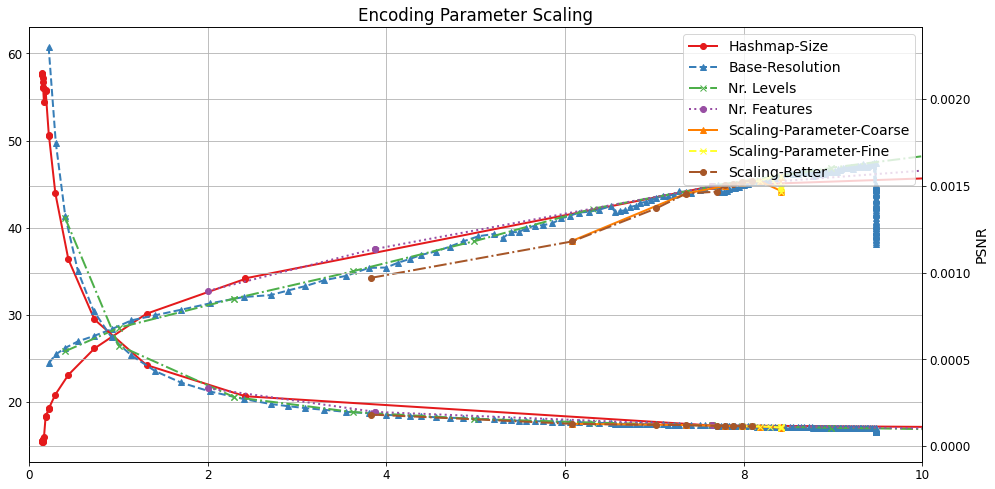

In [113]:
# Select the two columns for the scatter plot
plt.figure(figsize=(16, 8))

fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

plt.xlim(0, 10)  # Set the minimum and maximum values for the x-axis
# plt.ylim(15, 50)  # Set the minimum and maximum values for the y-axis

i = 0
for data, label in zip(agg_data, labels):
    sorted_data = data.sort_values(by='estimated_bpp', ascending=True)
    x_data = sorted_data['estimated_bpp']
    # y_data = np.log(sorted_data['psnr'])
    y_data_left = sorted_data['psnr']
    y_data_right = sorted_data['p_param_yield']
    
    marker_style = next(marker_styles)
    line_style = next(line_styles)
    
    ax1.plot(x_data, y_data_left, color=color_palette1[i], label=f"""{label}""", marker=marker_style, linestyle=line_style)
    ax2.plot(x_data, y_data_right, color=color_palette1[i], label=f"""{label}""", marker=marker_style, linestyle=line_style)
    i += 1

# Add labels and title
plt.xlabel('estimated bpp')
plt.ylabel('PSNR')
plt.title('Encoding Parameter Scaling')

# Show the plot
plt.legend()
plt.savefig('parameter_scaling_bpp_psnr.png')
plt.show()

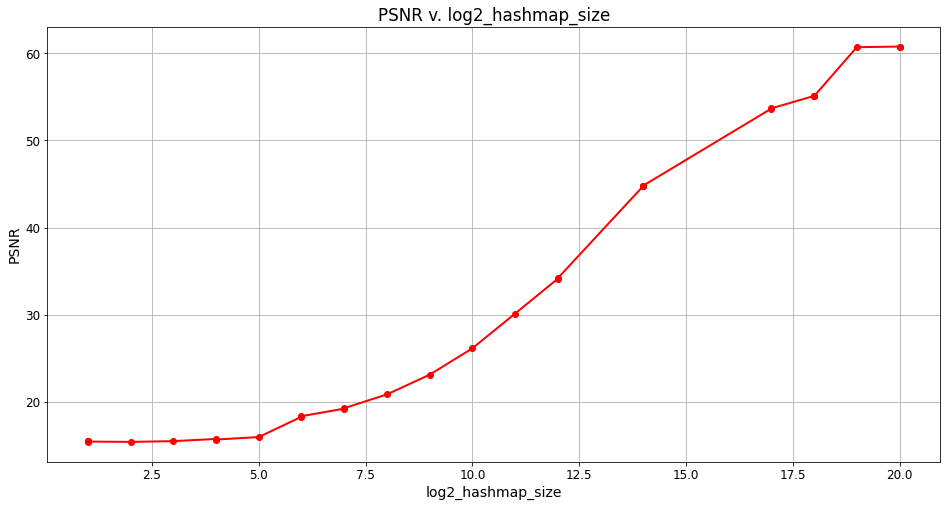

In [93]:
# Select the two columns for the scatter plot
param = "log2_hashmap_size"

plt.figure(figsize=(16, 8))
for data in agg_data:
    sorted_data = data.sort_values(by=f"""{param}""", ascending=True)
    x_data = sorted_data[f"""{param}"""]
    y_data = sorted_data['psnr']
    break

# Reduce the x-axis range
# plt.xlim(0, 1)  # Set the minimum and maximum values for the x-axis
# plt.ylim(14, 45)  # Set the minimum and maximum values for the x-axis

# Create the scatter plot
plt.plot(x_data, y_data, color="red", marker="o", linestyle="-")

# Add labels and title
plt.xlabel(f"""{param}""")
plt.ylabel('PSNR')
plt.title(f"""PSNR v. {param}""")

# Show the plot
plt.savefig(f"""{param}_psnr.png""")
plt.show()

In [201]:
((64**2 + 64 * 3 + 64 * 2) * 8) / (512 * 768)

0.08984375

In [ ]:
# Select the two columns for the scatter plot
plt.figure(figsize=(16, 8))

plt.xlim(0, 2.5)  # Set the minimum and maximum values for the x-axis
# plt.ylim(0, 40)  # Set the minimum and maximum values for the y-axis

# Draw lines
# plt.axhline(y=30, color='red', linestyle='--')
# plt.axvline(x=0.125, color='red', linestyle='--')
# plt.axvline(x=1, color='blue', linestyle='--')

color_palette = sns.color_palette('Set1')  # You can try other palettes like 'Dark2', 'Paired', etc.
i=0
for data, label in zip(agg_data, labels):
    x_data = data['estimated_bpp']
    y_data = data['p_param_yield']
    # z_data = aggregated_data['log2_hashmap_size']
    
    plt.scatter(x_data, y_data, color=color_palette[i], label=f"""{label}""")
    i+=1
    # plt.scatter(x_data, y_data, c=z_data, cmap='jet')
    
# Add a colorbar for reference
# plt.colorbar(label='per_level_scale')

# Add labels and title
plt.xlabel('estimated bpp')
plt.ylabel('PSNR')
plt.title('PSNR v. estimated bpp')

# Show the plot
plt.legend()
# plt.savefig('bpp_psnr.png')
plt.show()

In [46]:
import sys
util_path = '/cluster/home/jpostels/nnaimi/instant-ngp/scripts'
sys.path.append(util_path)

from common import *
from scenes import *

In [47]:
path_to_image = "/cluster/work/cvl/jpostels/nnaimi/data/KODAK/kodim11.png"

In [53]:
im = read_image(path_to_image)

(512, 768, 3)